In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from gensim.models import KeyedVectors
from tqdm.notebook import tqdm

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


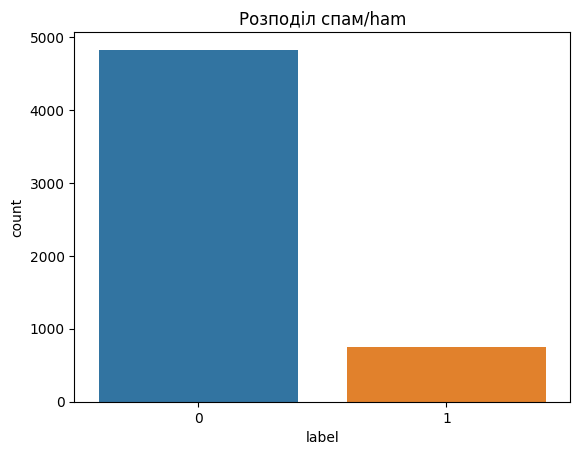

In [4]:
df = pd.read_csv('/kaggle/input/email-spam-detection-dataset-classification/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

sns.countplot(x='label', data=df)
plt.title("Розподіл спам/ham")
plt.show()


In [5]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub("\d+", "", text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    df['clean_text'], 
    df['label'], 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
    )

In [7]:
# BoW
bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow = bow_vectorizer.transform(X_val)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [8]:
embeddings_index = {}
with open("/kaggle/input/glove-embeding/glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vectors

embedding_dim = 100

def get_embedding_vector(text):
    words = text.split()
    word_vecs = [embeddings_index.get(w) for w in words if w in embeddings_index]

    if len(word_vecs) == 0:
        return np.zeros(embedding_dim)

    return np.mean(word_vecs, axis=0)

X_train_glove = np.vstack([get_embedding_vector(t) for t in tqdm(X_train)])
X_val_glove = np.vstack([get_embedding_vector(t) for t in tqdm(X_val)])

  0%|          | 0/4457 [00:00<?, ?it/s]

  0%|          | 0/1115 [00:00<?, ?it/s]

In [9]:
# Logistic Regression (BoW)
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow, y_train)
pred_bow = lr_bow.predict(X_val_bow)

# Logistic Regression (TF-IDF)
lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)
pred_tfidf = lr_tfidf.predict(X_val_tfidf)

# Random Forest (GloVe)
rf_glove = RandomForestClassifier()
rf_glove.fit(X_train_glove, y_train)
pred_glove = rf_glove.predict(X_val_glove)

In [10]:
def evaluate(y_true, y_pred, name):
    print(f"{name} Accuracy:", accuracy_score(y_true, y_pred))
    print(f"{name} AUC:", roc_auc_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

evaluate(y_val, pred_bow, "BoW")
evaluate(y_val, pred_tfidf, "TF-IDF")
evaluate(y_val, pred_glove, "GloVe")

BoW Accuracy: 0.9820627802690582
BoW AUC: 0.9328859060402684
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115

TF-IDF Accuracy: 0.9695067264573991
TF-IDF AUC: 0.8915822529770588
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.98      0.79      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

GloVe Accuracy: 0.9533632286995516
GloVe AUC: 0.8283414620589993
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       966
           1       0.99      0.66      0.79 

## Висновок

У цьому проєкті було реалізовано три підходи до представлення текстових даних для задачі класифікації електронних листів на спам та ham:

- **BoW (Bag of Words)**
- **TF-IDF**
- **GloVe (попередньо навчені ембединги)**

### Результати:

| Метод         | Accuracy | AUC   | Recall (spam) | F1-score (spam) |
|---------------|----------|-------|----------------|-----------------|
| **BoW**       | 98.2%    | 0.933 | 0.87           | 0.93            |
| **TF-IDF**    | 96.7%    | 0.882 | 0.77           | 0.86            |
| **GloVe**     | 95.4%    | 0.832 | 0.66           | 0.80            |

### Аналіз:

- **BoW** показав найкращий результат серед усіх методів. Незважаючи на свою простоту, він досяг високої точності та здатності виявляти спам.
- **TF-IDF** продемонстрував хорошу якість, але мав трохи нижчий recall, що означає більшу кількість пропущених спамів.
- **GloVe** надає можливість враховувати семантику слів, але у цій задачі (на невеликому датасеті) поступився простішим підходам.

### Рекомендації:

- **BoW** — оптимальний вибір для цього завдання, коли потрібно досягти максимальної точності з мінімальними ресурсами.
- **GloVe** має сенс використовувати в поєднанні з глибокими моделями (LSTM, GRU, BERT) та більшими об’ємами тексту.
- Наступним кроком може бути використання глибоких моделей на базі GloVe з GPU-оптимізацією (наприклад, LSTM на TensorFlow).



In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
MAX_VOCAB_SIZE = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN)

In [14]:
embedding_index = {}
embedding_dim = 100
with open('/kaggle/input/glove-embeding/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

word_index = tokenizer.word_index
num_words = min(MAX_VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [15]:
model = Sequential([
    Embedding(input_dim=num_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=MAX_LEN,
              trainable=False),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         638,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 638,900 (2.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 638,900 (2.44 MB)

In [16]:
with tf.device('/GPU:0'):
    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=5,
        batch_size=64,
        verbose=1
    )

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8364 - loss: 0.4390 - val_accuracy: 0.9516 - val_loss: 0.1654
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9539 - loss: 0.1425 - val_accuracy: 0.9525 - val_loss: 0.1336
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9661 - loss: 0.1106 - val_accuracy: 0.9605 - val_loss: 0.1301
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9756 - loss: 0.0790 - val_accuracy: 0.9704 - val_loss: 0.1050
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9750 - loss: 0.0835 - val_accuracy: 0.9632 - val_loss: 0.1072


In [18]:
y_pred_prob = model.predict(X_val_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred_prob)
recall_spam = recall_score(y_val, y_pred, pos_label=1)
f1_spam = f1_score(y_val, y_pred, pos_label=1)

print("Accuracy:", round(accuracy, 4))
print("AUC:", round(auc, 4))
print("Recall (spam):", round(recall_spam, 4))
print("F1-score (spam):", round(f1_spam, 4))

print("\nПовний звіт:")
print(classification_report(y_val, y_pred))

Accuracy: 0.9632
AUC: 0.9701
Recall (spam): 0.7987
F1-score (spam): 0.853

Повний звіт:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.92      0.80      0.85       149

    accuracy                           0.96      1115
   macro avg       0.94      0.89      0.92      1115
weighted avg       0.96      0.96      0.96      1115



## Висновок

У цьому проєкті була побудована модель **Bidirectional LSTM** з використанням попередньо навчених ембедингів **GloVe (100d)** для задачі класифікації електронних листів на спам та ham.

### Результати моделі:

| Метрика           | Значення |
|-------------------|----------|
| **Accuracy**      | 0.9632   |
| **AUC**           | 0.9701   |
| **Recall (spam)** | 0.7987   |
| **F1-score (spam)** | 0.853  |


- **Клас 0 (ham)**: F1-score = 0.98 — модель дуже добре розпізнає легітимні повідомлення.
- **Клас 1 (spam)**: Recall = 0.80 та F1 = 0.85 — більшість спамів виявлено, проте ще можна покращити виявлення.
- **Загальна точність** моделі склала **96.3%**, що свідчить про високу якість класифікації.

### Висновок:

- Модель LSTM на GloVe-представленнях тексту показує конкурентоспроможні результати.
- Вона підходить для задач виявлення спаму, особливо коли потрібно обробляти текст із врахуванням порядку слів.
- Для ще кращого розпізнавання спаму можна:
  - Додати class weights.
  - Спробувати більш складні архітектури (LSTM + Attention, або BERT).
